# NYC Taxi Feature Engineering and Prediction
### Goals
- Feature engineering
    - Datetime
    - Reverse geocoding (long/lat --> zip)
    - Categorical data (zipcode): label encoding
- Prediction Models
    - Baseline simple linear model
    - XGBoost regressor
    - LightGBM regressor
    - Random forest regressor
    
### Import Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

from google.cloud import bigquery
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
%matplotlib inline

### Load Data
Assume we're making prediction at certain date. Information like number of passengers, trip distance, dropoff location, etc. will not be available for future trips so we will only use pickup location and time.

In [2]:
client = bigquery.Client()

Using Kaggle's public dataset BigQuery integration.


In [3]:
dataset_ref = client.dataset('new_york_taxi_trips', project='bigquery-public-data')
dataset = client.get_dataset(dataset_ref)
table_ref = dataset_ref.table('tlc_yellow_trips_2015')
table = client.get_table(table_ref)

client.list_rows(table, max_results=5).to_dataframe()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,imp_surcharge,total_amount
0,2,2015-10-19 14:42:59,2015-10-19 14:47:06,2,0.65,-73.964737,40.767078,1.0,N,-73.962372,40.773129,2,5.0,0.0,0.5,0.00,0.0,0.3,5.80
1,1,2015-11-24 12:28:25,2015-11-24 12:37:33,1,0.60,-73.985336,40.744019,1.0,N,-73.991112,40.748569,1,7.0,0.0,0.5,1.55,0.0,0.3,9.35
2,2,2015-11-21 20:21:37,2015-11-21 20:44:19,1,2.65,-73.972588,40.755905,1.0,N,-74.000000,40.730560,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30
3,1,2015-08-20 15:19:46,2015-08-20 15:23:58,1,0.60,-73.989464,40.767578,1.0,N,-73.978683,40.765167,2,4.5,0.0,0.5,0.00,0.0,0.3,5.30
4,2,2015-01-08 20:59:40,2015-01-08 21:09:31,1,1.74,-73.983673,40.765610,NaN,N,-73.976959,40.785778,2,9.0,0.5,0.5,0.00,0.0,0.3,10.30


Feature engineering for datetime can be done when we load data.

In [4]:
%%time
query = '''
        WITH base_data AS (
          SELECT nyc_taxi.*, gis.* EXCEPT (zip_code_geom)
          FROM (
            SELECT pickup_longitude, pickup_latitude, pickup_datetime
            FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
            WHERE EXTRACT(MONTH FROM pickup_datetime) = 1
            AND pickup_latitude  <= 90 AND pickup_latitude >= -90
            ) AS nyc_taxi
          JOIN (
            SELECT zip_code, zip_code_geom
            FROM `bigquery-public-data.geo_us_boundaries.zip_codes`
            WHERE state_code='NY'
            ) AS gis
          ON ST_CONTAINS(zip_code_geom, st_geogpoint(pickup_longitude, pickup_latitude))
        )
        SELECT
            zip_code,
            DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour,
            EXTRACT(DAY FROM pickup_datetime) AS day,
            CAST(FORMAT_DATETIME('%u', pickup_datetime) AS INT64) - 1 AS dow,
            EXTRACT(HOUR FROM pickup_datetime) AS hour,
            CASE WHEN CAST(FORMAT_DATETIME('%u',pickup_datetime) AS INT64) IN (6,7) THEN 1 ELSE 0 END AS is_weekend,
            COUNT(1) AS cnt
        FROM base_data
        GROUP BY zip_code, pickup_hour, day, dow, hour, is_weekend
        ORDER BY pickup_hour
        '''


safe_config = bigquery.QueryJobConfig(maximum_bytes_billed = 10**10)
query_job = client.query(query, job_config=safe_config)
df = query_job.to_dataframe()

CPU times: user 5.1 s, sys: 509 ms, total: 5.61 s
Wall time: 37.9 s


In [5]:
df.head()

,zip_code,pickup_hour,day,dow,hour,is_weekend,cnt
0,10003,2015-01-01,1,3,0,0,1809
1,10025,2015-01-01,1,3,0,0,784
2,10028,2015-01-01,1,3,0,0,835
3,10075,2015-01-01,1,3,0,0,444
4,10032,2015-01-01,1,3,0,0,64


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87020 entries, 0 to 87019
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   zip_code     87020 non-null  object        
 1   pickup_hour  87020 non-null  datetime64[ns]
 2   day          87020 non-null  int64         
 3   dow          87020 non-null  int64         
 4   hour         87020 non-null  int64         
 5   is_weekend   87020 non-null  int64         
 6   cnt          87020 non-null  int64         
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 4.6+ MB


In [7]:
df.describe()

,day,dow,hour,is_weekend,cnt
count,87020.000000,87020.000000,87020.000000,87020.000000,87020.000000
mean,15.871685,3.169593,11.580648,0.303838,141.603080
std,8.951484,1.936788,6.973099,0.459916,306.902683
min,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.000000,2.000000,6.000000,0.000000,2.000000
50%,16.000000,3.000000,12.000000,0.000000,12.000000
75%,24.000000,5.000000,18.000000,1.000000,80.000000
max,31.000000,6.000000,23.000000,1.000000,2657.000000


### One Hot Encoding
Since we will first train a linear model, we will process one hot encoder to process zipcode.

In [8]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
onehot_output = enc.fit_transform(df[['zip_code']]).toarray()
onehot_df = pd.concat([df, pd.DataFrame(onehot_output, columns='zip_code_' + enc.categories_[0])], axis=1)
onehot_df.head()

,zip_code,pickup_hour,day,dow,hour,is_weekend,cnt,zip_code_10001,zip_code_10002,zip_code_10003,...,zip_code_12601,zip_code_12729,zip_code_12771,zip_code_13029,zip_code_13118,zip_code_13656,zip_code_13691,zip_code_14072,zip_code_14527,zip_code_14801
0,10003,2015-01-01,1,3,0,0,1809,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10025,2015-01-01,1,3,0,0,784,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10028,2015-01-01,1,3,0,0,835,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10075,2015-01-01,1,3,0,0,444,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10032,2015-01-01,1,3,0,0,64,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Target Variable Distribution

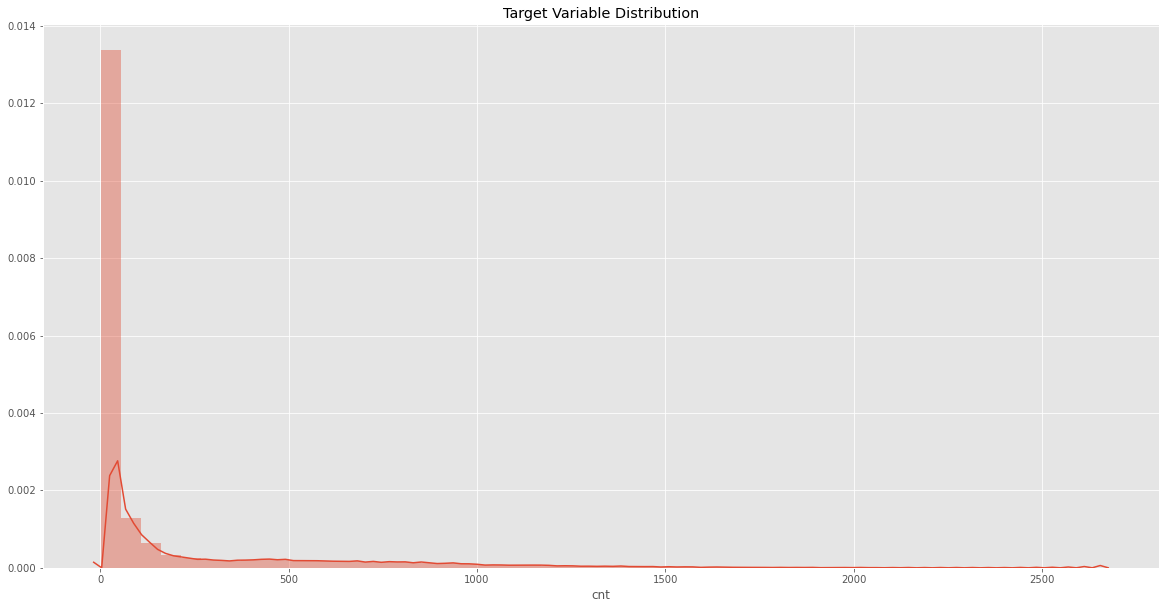

In [9]:
plt.figure(figsize=(20,10))
sns.distplot(onehot_df['cnt'])
plt.title('Target Variable Distribution');

In [10]:
onehot_df['log_cnt'] = np.log(onehot_df['cnt'])

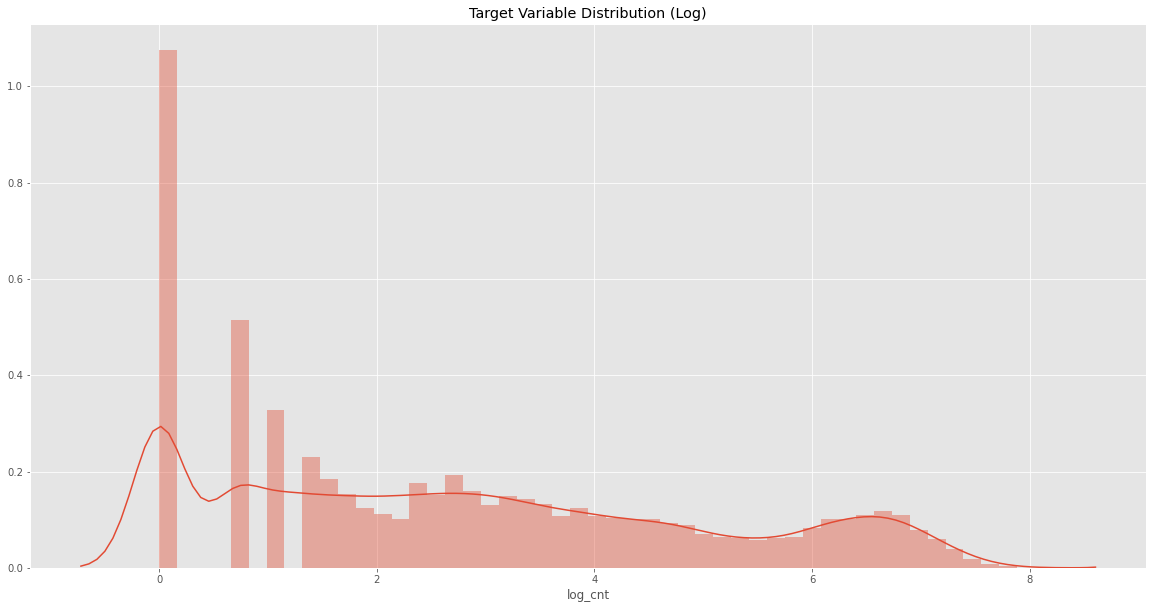

In [11]:
plt.figure(figsize=(20,10))
sns.distplot(onehot_df['log_cnt'])
plt.title('Target Variable Distribution (Log)');

### Train/Test Split
Since our data is time series data, we sill pick a specific date and assume prediction is made on that date. Data prior to the date will be train data and data after the date will be test data.

In [12]:
def train_test_split(df, date):
    '''
    Split dataframe into train set and test set
    
    df: time series df
    date: date at which prediction is made
    '''
    train_df = df[df['pickup_hour'] < date]
    test_df = df[df['pickup_hour'] >= date]
    return train_df, test_df

In [13]:
train_df, test_df = train_test_split(onehot_df, '2015-1-24')

Remove unused columns.

In [14]:
train_df.drop(['pickup_hour', 'zip_code'], axis=1, inplace=True)
test_df.drop(['pickup_hour', 'zip_code'], axis=1, inplace=True)

In [15]:
train_df.head()

,day,dow,hour,is_weekend,cnt,zip_code_10001,zip_code_10002,zip_code_10003,zip_code_10004,zip_code_10005,...,zip_code_12729,zip_code_12771,zip_code_13029,zip_code_13118,zip_code_13656,zip_code_13691,zip_code_14072,zip_code_14527,zip_code_14801,log_cnt
0,1,3,0,0,1809,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.500529
1,1,3,0,0,784,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.664409
2,1,3,0,0,835,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.727432
3,1,3,0,0,444,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.095825
4,1,3,0,0,64,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.158883


In [16]:
test_df.head()

,day,dow,hour,is_weekend,cnt,zip_code_10001,zip_code_10002,zip_code_10003,zip_code_10004,zip_code_10005,...,zip_code_12729,zip_code_12771,zip_code_13029,zip_code_13118,zip_code_13656,zip_code_13691,zip_code_14072,zip_code_14527,zip_code_14801,log_cnt
65118,24,5,0,1,41,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.713572
65119,24,5,0,1,36,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.583519
65120,24,5,0,1,2315,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.747165
65121,24,5,0,1,516,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.246107
65122,24,5,0,1,83,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.418841


In [17]:
y_train_raw = train_df.pop('cnt')
y_test_raw = test_df.pop('cnt')
y_train_log = train_df.pop('log_cnt')
y_test_log = test_df.pop('log_cnt')
X_train = train_df.copy()
X_test = test_df.copy()

### Simple Linear Regression

Define function for evaluation.

In [18]:
def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    return {'mae': mae, 'rmse':np.sqrt(mse)}

Fit baseline linear regression model.

In [19]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train_log)
lr_pred = lr.predict(X_test)

In [20]:
lr_eval = evaluate(y_test_raw, np.exp(lr_pred))
lr_eval

{'mae': 66.94405290178089, 'rmse': 164.3810176941835}

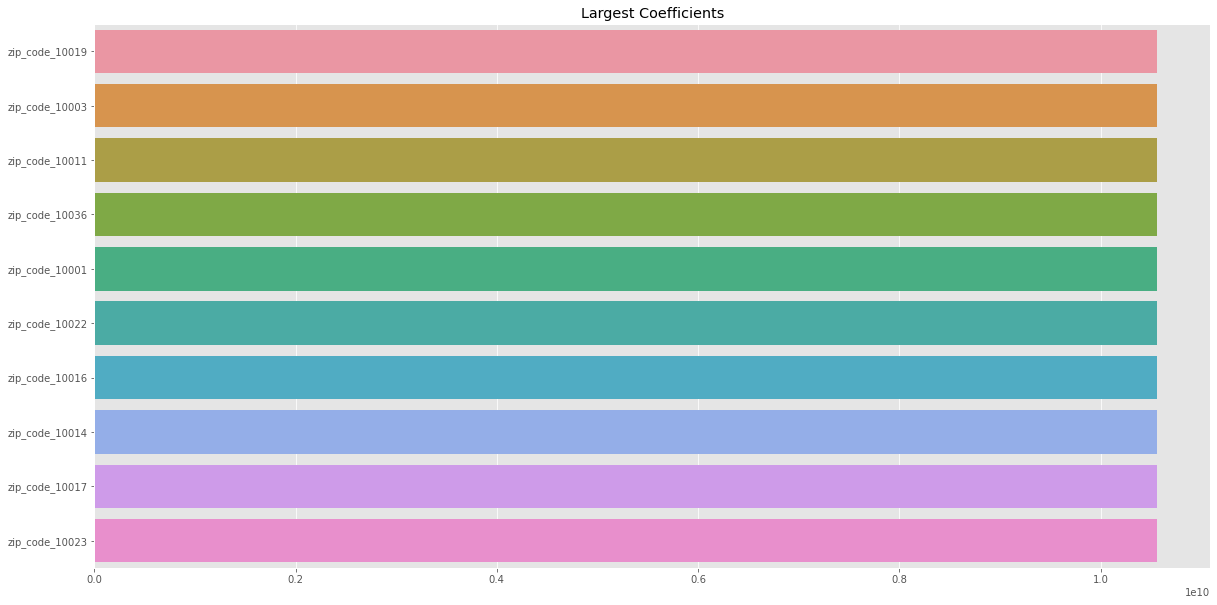

In [21]:
coef = pd.Series(lr.coef_ , index=X_train.columns)
coef_sort = coef.sort_values(ascending=False)[:10]

plt.figure(figsize=(20,10))
sns.barplot(x=coef_sort.values , y=coef_sort.index)
plt.title('Largest Coefficients');

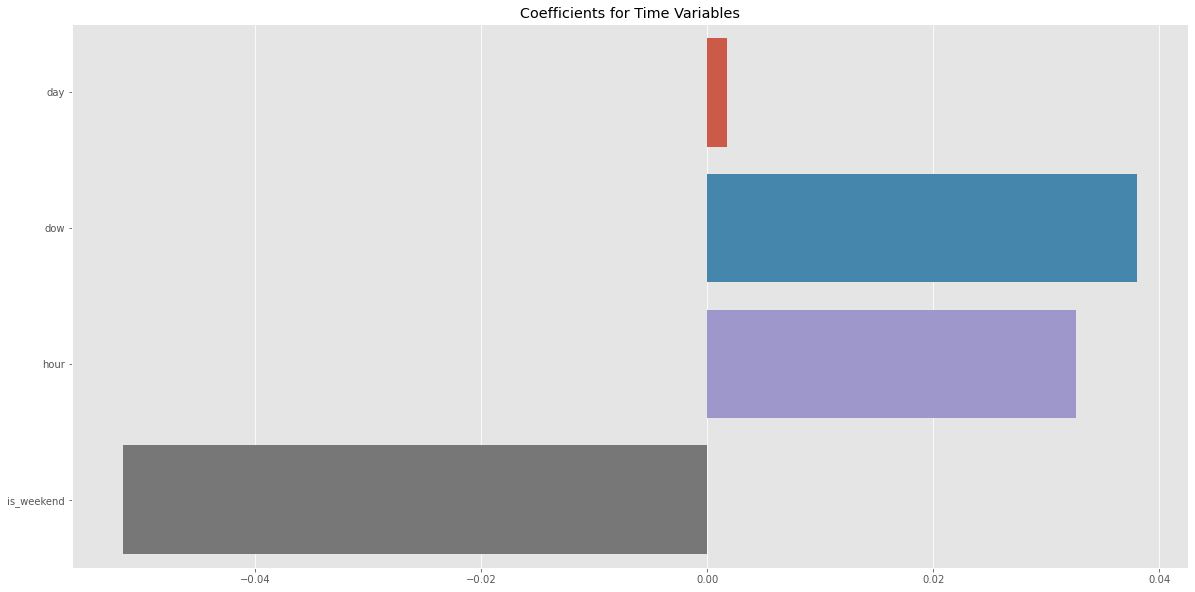

In [22]:
plt.figure(figsize=(20,10))
sns.barplot(x=coef[['day','dow','hour','is_weekend']] , y=['day','dow','hour','is_weekend'])
plt.title('Coefficients for Time Variables');

### Label Encoding
Since many of the variables are categorical/ordinal, distance based models may not be our best choice. We will use some tree based models. Use label encoder for tree based models.

In [23]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['zip_code_label'] = le.fit_transform(df['zip_code'])

In [24]:
df.head()

,zip_code,pickup_hour,day,dow,hour,is_weekend,cnt,zip_code_label
0,10003,2015-01-01,1,3,0,0,1809,2
1,10025,2015-01-01,1,3,0,0,784,22
2,10028,2015-01-01,1,3,0,0,835,25
3,10075,2015-01-01,1,3,0,0,444,41
4,10032,2015-01-01,1,3,0,0,64,29


In [25]:
train_df, test_df = train_test_split(df, '2015-01-24')

In [26]:
train_df.drop(['zip_code','pickup_hour'], axis=1, inplace=True)
test_df.drop(['zip_code','pickup_hour'], axis=1, inplace=True)

In [27]:
y_train = train_df.pop('cnt')
y_test = test_df.pop('cnt')
X_train = train_df.copy()
X_test = test_df.copy()

### Random Forest

In [28]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1)
param = { 
    'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [5, 7, 10, None]
}

rf_grid = GridSearchCV(estimator=rf, param_grid=param, cv=3, verbose=2, n_jobs=-1)
rf_grid.fit(X_train, y_train)
rf_grid.best_params_

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  6.8min finished


{'max_depth': None, 'max_features': 'auto', 'n_estimators': 500}

In [29]:
rf = RandomForestRegressor(**rf_grid.best_params_, n_jobs=-1)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

In [30]:
rf_eval = evaluate(y_test, rf_pred)
rf_eval

{'mae': 34.669216875171216, 'rmse': 109.61552542910226}

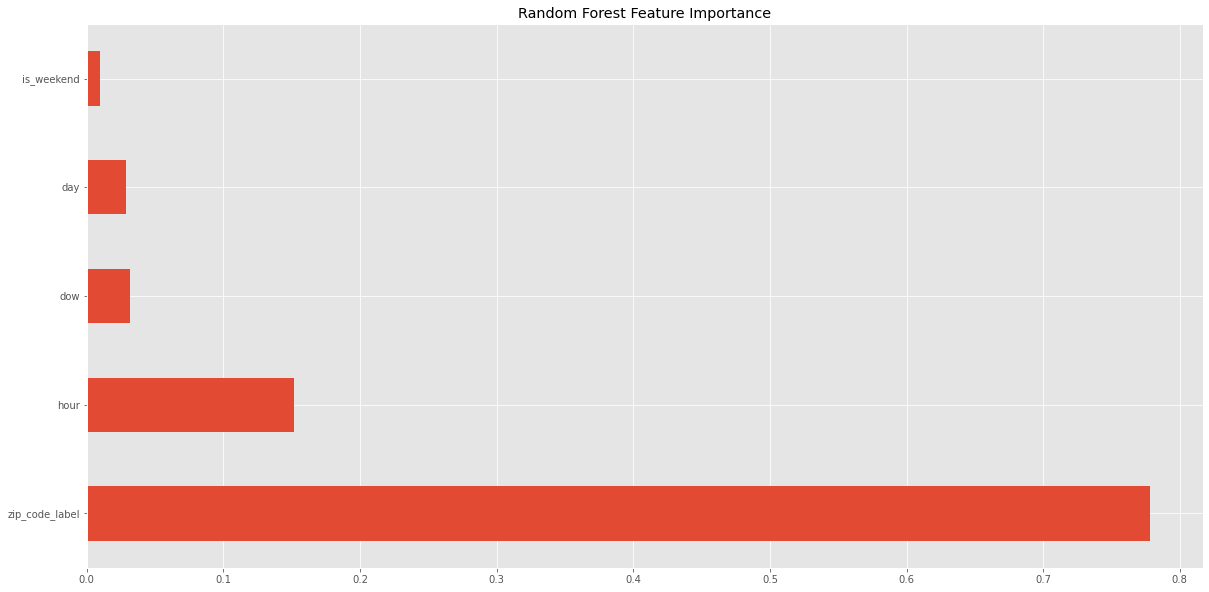

In [31]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
plt.figure(figsize=(20,10))
feat_importances.nlargest(15).plot(kind='barh')
plt.title('Random Forest Feature Importance');

### XGBoost

In [32]:
from xgboost import XGBRegressor
xgb = XGBRegressor(n_jobs=-1)
param = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0, 0.5, 1, 2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 6]
        }
xgb_grid = GridSearchCV(estimator=xgb, param_grid=param, cv=3, verbose=2, n_jobs=-1)
xgb_grid.fit(X_train, y_train)
xgb_grid.best_params_

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done 1296 out of 1296 | elapsed: 17.1min finished


{'colsample_bytree': 1.0,
 'gamma': 1,
 'max_depth': 6,
 'min_child_weight': 10,
 'subsample': 0.8}

In [33]:
xgb = XGBRegressor(**xgb_grid.best_params_, n_jobs=-1)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

In [34]:
xgb_eval = evaluate(y_test, xgb_pred)
xgb_eval

{'mae': 43.135387968376406, 'rmse': 117.67278475633721}

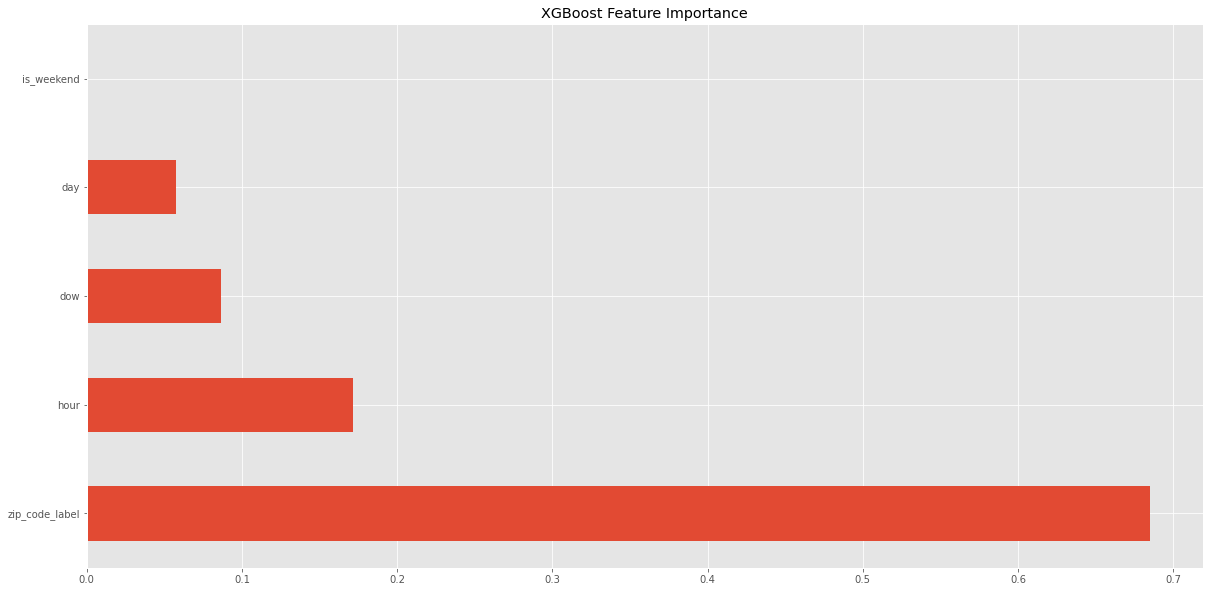

In [35]:
feat_importances = pd.Series(xgb.feature_importances_, index=X_train.columns)
plt.figure(figsize=(20,10))
feat_importances.nlargest(15).plot(kind='barh')
plt.title('XGBoost Feature Importance');

### LightGBM

In [36]:
from lightgbm import LGBMRegressor
lgbm = LGBMRegressor(n_jobs=-1)
param = {'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200],
    'num_leaves': [16, 31], # large num_leaves helps improve accuracy but might lead to over-fitting
    'colsample_bytree' : [0.6, 0.8, 1.0],
    'subsample' : [0.6, 0.8, 1.0],
    }

lgbm_grid = GridSearchCV(estimator=lgbm, param_grid=param, cv=3, verbose=2, n_jobs=-1)
lgbm_grid.fit(X_train, y_train)
lgbm_grid.best_params_

Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   51.6s
[Parallel(n_jobs=-1)]: Done 486 out of 486 | elapsed:  1.3min finished


{'colsample_bytree': 1.0,
 'learning_rate': 0.1,
 'n_estimators': 200,
 'num_leaves': 31,
 'subsample': 0.6}

In [37]:
lgbm = LGBMRegressor(**lgbm_grid.best_params_, n_jobs=-1)
lgbm.fit(X_train, y_train)
lgbm_pred = lgbm.predict(X_test)

In [38]:
lgbm_eval = evaluate(y_test_raw, lgbm_pred)

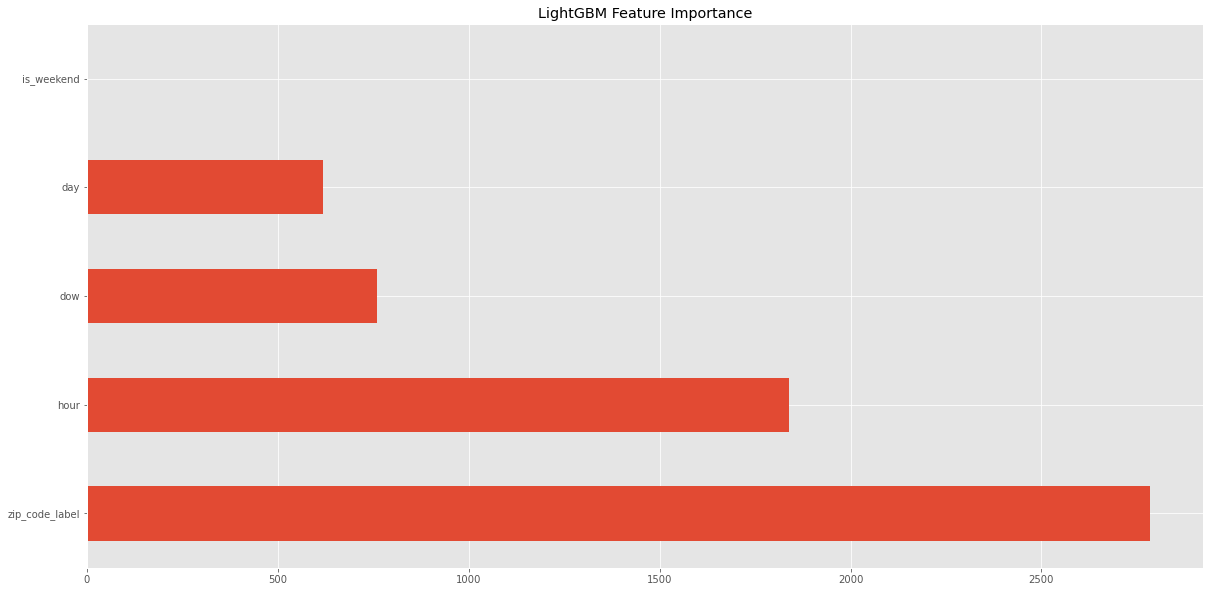

In [39]:
feat_importances = pd.Series(lgbm.feature_importances_, index=X_train.columns)
plt.figure(figsize=(20,10))
feat_importances.nlargest(15).plot(kind='barh')
plt.title('LightGBM Feature Importance');

### Results
Among all the models trained, Random Forest had the best performance.

In [40]:
results = pd.DataFrame.from_dict([lr_eval, rf_eval, xgb_eval, lgbm_eval])
results.index=['linear','random forest','xgboost','lgbm']
results

,mae,rmse
linear,66.944053,164.381018
random forest,34.669217,109.615525
xgboost,43.135388,117.672785
lgbm,43.791455,115.520945


In [41]:
test_df['cnt'] = y_test
test_df['lr_pred'] = np.exp(lr_pred)
test_df['rf_pred'] = rf_pred
test_df['xgb_pred'] = xgb_pred
test_df['lgbm_pred'] = lgbm_pred
test_df['zip_code'] = le.inverse_transform(test_df['zip_code_label'])
test_df['month'] = 1
test_df['year'] = 2015
test_df['datetime'] = pd.to_datetime(test_df[['year', 'month', 'day', 'hour']])

In [42]:
test_df.head()

,day,dow,hour,is_weekend,zip_code_label,cnt,lr_pred,rf_pred,xgb_pred,lgbm_pred,zip_code,month,year,datetime
65118,24,5,0,1,28,41,14.467897,45.038,52.227070,35.001701,10031,1,2015,2015-01-24
65119,24,5,0,1,194,36,5.501186,51.624,43.799358,28.894170,11205,1,2015,2015-01-24
65120,24,5,0,1,2,2315,563.514055,2418.618,2301.500732,2374.958964,10003,1,2015,2015-01-24
65121,24,5,0,1,15,516,270.242434,539.080,678.877563,604.175562,10018,1,2015,2015-01-24
65122,24,5,0,1,245,83,110.410636,201.318,198.481979,186.107128,11371,1,2015,2015-01-24


In [43]:
test_df.groupby('datetime')['cnt','lr_pred','rf_pred','xgb_pred','lgbm_pred','zip_code'].sum().iplot(kind='scatter', title='Prediction by Datetime', xTitle='Datetime', yTitle='Count')

<img src="https://github.com/jiyoungsim/BigQuery-NYC-Taxi-Demand--EDA-and-Prediction/blob/master/figs/pred_by_datetime.png?raw=true">

In [44]:
test_df.groupby('zip_code')['cnt','lr_pred','rf_pred','xgb_pred','lgbm_pred','zip_code'].sum().iplot(kind='scatter', title='Prediction by Zipcode', xTitle='Zipcode', yTitle='Count')

<img src="https://github.com/jiyoungsim/BigQuery-NYC-Taxi-Demand--EDA-and-Prediction/blob/master/figs/pred_by_zip.png?raw=true">

In [45]:
test_df.groupby('hour')['cnt','lr_pred','rf_pred','xgb_pred','lgbm_pred','zip_code'].sum().iplot(kind='scatter', title='Prediction by Hour', xTitle='Hour', yTitle='Count')

<img src="https://github.com/jiyoungsim/BigQuery-NYC-Taxi-Demand--EDA-and-Prediction/blob/master/figs/pred_by_hour.png?raw=true">

In [46]:
test_df.groupby('dow')['cnt','lr_pred','rf_pred','xgb_pred','lgbm_pred','zip_code'].sum().rename(index={0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}).iplot(kind='scatter', title='Prediction by Day of Week', xTitle='Day of Week', yTitle='Count')

<img src="https://github.com/jiyoungsim/BigQuery-NYC-Taxi-Demand--EDA-and-Prediction/blob/master/figs/pred_by_dow.png?raw=true">

In [47]:
test_df.groupby('day')['cnt','lr_pred','rf_pred','xgb_pred','lgbm_pred','zip_code'].sum().iplot(kind='scatter', title='Prediction by Day', xTitle='Day', yTitle='Count')

<img src="https://github.com/jiyoungsim/BigQuery-NYC-Taxi-Demand--EDA-and-Prediction/blob/master/figs/pred_by_day.png?raw=true">

In [48]:
test_df.groupby('is_weekend')['cnt','lr_pred','rf_pred','xgb_pred','lgbm_pred','zip_code'].sum().rename(index={0:'Weekday', 1:'Weekend'}).iplot(kind='bar', title='Prediction by Weekday/Weekend',yTitle='Count')

<img src="https://github.com/jiyoungsim/BigQuery-NYC-Taxi-Demand--EDA-and-Prediction/blob/master/figs/pred_by_is_weekend.png?raw=true">